In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import math
import statistics
import scipy.stats
from scipy import stats
# !pip install researchpy
import numpy as np
# !pip install pingouin
import pingouin as pg
import pandas as pd
import researchpy as rp
import scipy.stats as stats
from scipy.stats import f_oneway
import statsmodels.formula.api as smf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#De data binnenhalen
train = pd.read_csv("/content/drive/My Drive/minor/stats/log/train.csv", sep =",")
train.shape

(103904, 25)

In [3]:
#onnodige kolommen weg doen
train = train.drop('Unnamed: 0', axis=1)
train = train.drop('id', axis=1)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

In [5]:
train.columns = [c.replace(' ', '_') for c in train.columns]
train['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1},inplace = True)

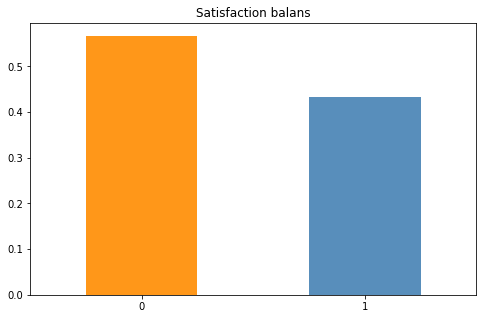

In [6]:
# Kijken of de satisfaction gebalanceerd is
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
train.satisfaction.value_counts(normalize = True).plot(kind='bar', color= ['darkorange','steelblue'], alpha = 0.9, rot=0)
plt.title('Satisfaction balans')
plt.show()

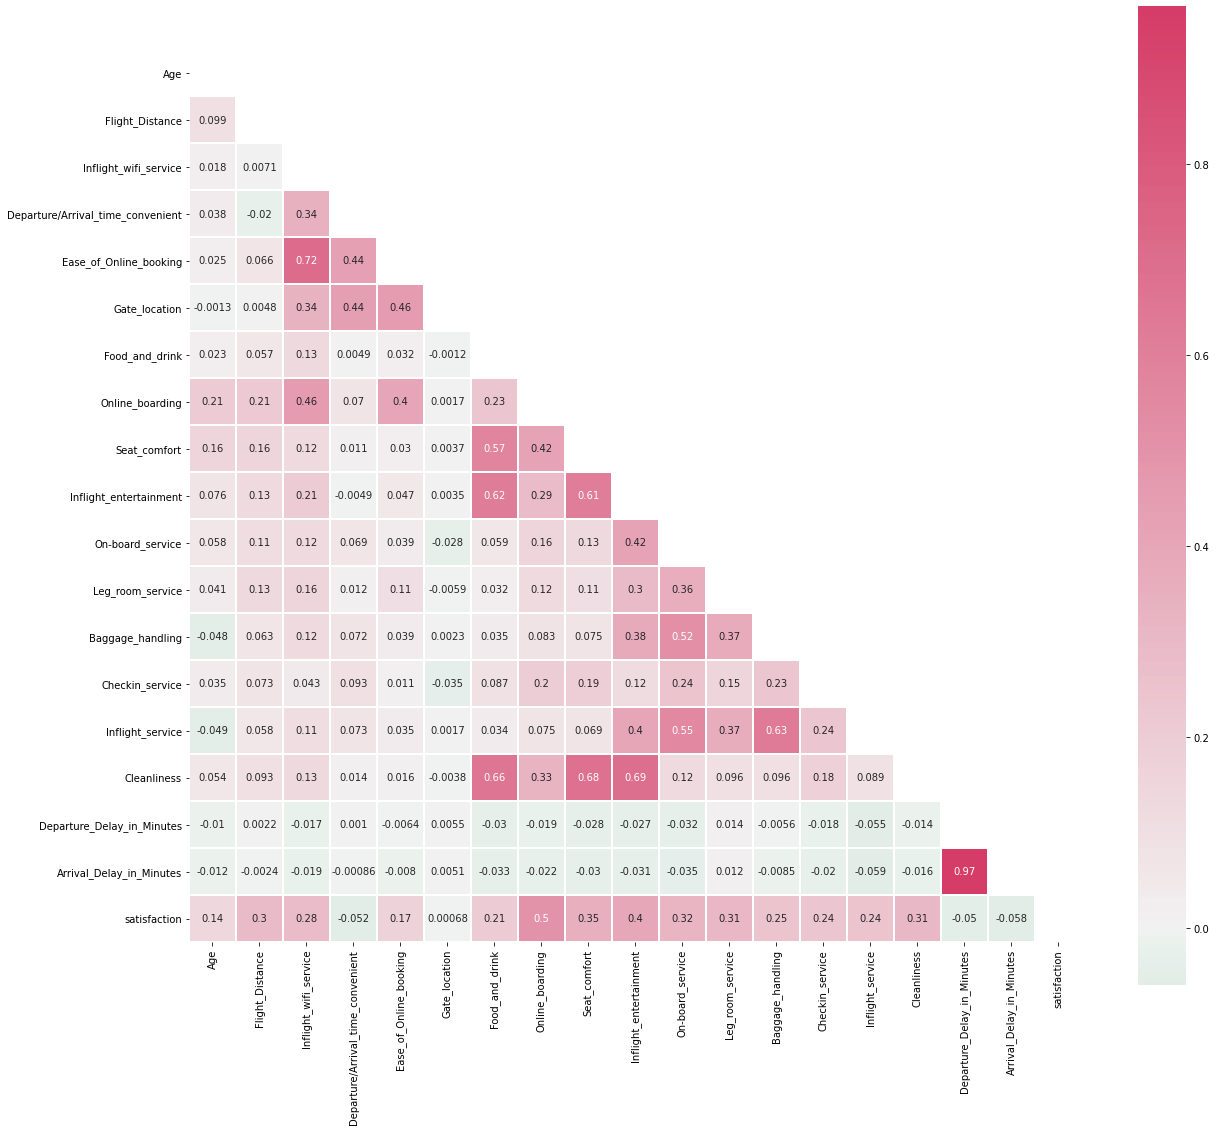

In [7]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(150, 1, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

In [8]:
# waar zijn alle missende waardes
def missing_percent(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(df.isnull().sum().sort_values(ascending = False)/ len(df) * 100, 2)
    return pd.concat([total, percent], axis = 1, keys = ['Total', '%'])

In [9]:
missing_percent(train)

,Total,%
Arrival_Delay_in_Minutes,310,0.3
satisfaction,0,0.0
Food_and_drink,0,0.0
Customer_Type,0,0.0
Age,0,0.0
Type_of_Travel,0,0.0
Class,0,0.0
Flight_Distance,0,0.0
Inflight_wifi_service,0,0.0
Departure/Arrival_time_convenient,0,0.0


In [10]:
# Arrival delay heeft een lage correlatie, dus die kunnen we verwijderen aangezien alle missende waardes

In [11]:
train = train.drop('Arrival_Delay_in_Minutes', axis=1)

# De verdeling bekijken

In [12]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,103904.0,39.379706,15.114964,7.0,27.0,40.0,51.0,85.0
Flight_Distance,103904.0,1189.448375,997.147281,31.0,414.0,843.0,1743.0,4983.0
Inflight_wifi_service,103904.0,2.729683,1.327829,0.0,2.0,3.0,4.0,5.0
Departure/Arrival_time_convenient,103904.0,3.060296,1.525075,0.0,2.0,3.0,4.0,5.0
Ease_of_Online_booking,103904.0,2.756901,1.398929,0.0,2.0,3.0,4.0,5.0
Gate_location,103904.0,2.976883,1.277621,0.0,2.0,3.0,4.0,5.0
Food_and_drink,103904.0,3.202129,1.329533,0.0,2.0,3.0,4.0,5.0
Online_boarding,103904.0,3.250375,1.349509,0.0,2.0,3.0,4.0,5.0
Seat_comfort,103904.0,3.439396,1.319088,0.0,2.0,4.0,5.0,5.0
Inflight_entertainment,103904.0,3.358158,1.332991,0.0,2.0,4.0,4.0,5.0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Flight_Distance Distribution')

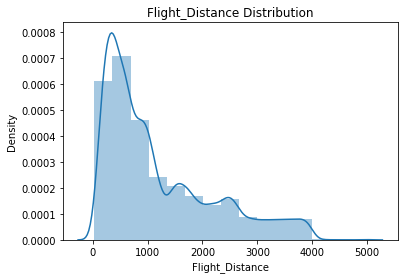

In [13]:
x = train['Flight_Distance']
sns.distplot(x, bins = 15)
plt.title('Flight_Distance Distribution')
# geen normaal distributie

FLight distance heeft een erg hoge gemiddelde en  standaard deviatie

# T-test

Testen doen om te kijken welke variabelen we gaan gebruiken in de regressie analyse. Er moet een significant verschil zijn en de effect grootte moet relatief groot zijn.

In [14]:
''' is er een verschil tussen satisfied/unsatisfied klanten als het 
om age, delay en flight distance gaat?'''
satisfied = train.loc[train['satisfaction'] == 1]
unsatisfied = train.loc[train['satisfaction'] == 0]

H0: er is geen significant verschil tussen de afstand en tevredenheid.

In [15]:
# Ttest om te zien of er in flight distance een verschil zit
stats.ttest_ind(satisfied.Flight_Distance,unsatisfied.Flight_Distance)

Ttest_indResult(statistic=100.91789690126286, pvalue=0.0)

H0: er is geen significant verschil tussen de leeftijd en tevredenheid.

In [16]:
# Ttest om te zien of er in age een verschil zit
stats.ttest_ind(satisfied.Age,unsatisfied.Age)

Ttest_indResult(statistic=44.63618618810881, pvalue=0.0)

H0: er is geen significant verschil tussen de afstand en tevredenheid.

In [17]:
# Ttest om te zien of er in delay een verschil zit
stats.ttest_ind(satisfied.Departure_Delay_in_Minutes,unsatisfied.Departure_Delay_in_Minutes)

Ttest_indResult(statistic=-16.297008708001417, pvalue=1.2293455496744246e-59)

Nog een keer t-test doen voor meer informatie. Hierna kijken we naar Pearsons R.

In [18]:
rp.ttest(group1= train['Flight_Distance'][train['satisfaction'] == 1], group1_name= "satisfied",
         group2= train['Flight_Distance'][train['satisfaction'] == 0], group2_name= "unsatisfied")

(      Variable         N         Mean  ...        SE    95% Conf.     Interval
 0    satisfied   45025.0  1530.140255  ...  5.316563  1519.719703  1540.560808
 1  unsatisfied   58879.0   928.919971  ...  3.257583   922.535095   935.304848
 2     combined  103904.0  1189.448375  ...  3.093451  1183.385253  1195.511498
 
 [3 rows x 7 columns],                         Independent t-test      results
 0  Difference (satisfied - unsatisfied) =      601.2203
 1                    Degrees of freedom =   103902.0000
 2                                     t =      100.9179
 3                 Two side test p value =        0.0000
 4                Difference < 0 p value =        1.0000
 5                Difference > 0 p value =        0.0000
 6                             Cohen's d =        0.6318
 7                             Hedge's g =        0.6318
 8                         Glass's delta =        0.5329
 9                                     r =        0.2988)

In [19]:
rp.ttest(group1= train['Departure_Delay_in_Minutes'][train['satisfaction'] == 1], group1_name= "satisfied",
         group2= train['Departure_Delay_in_Minutes'][train['satisfaction'] == 0], group2_name= "unsatisfied")

(      Variable         N       Mean         SD        SE  95% Conf.   Interval
 0    satisfied   45025.0  12.608084  35.382595  0.166749  12.281254  12.934915
 1  unsatisfied   58879.0  16.503728  40.191886  0.165637  16.179078  16.828378
 2     combined  103904.0  14.815618  38.230901  0.118604  14.583156  15.048080,
                         Independent t-test      results
 0  Difference (satisfied - unsatisfied) =       -3.8956
 1                    Degrees of freedom =   103902.0000
 2                                     t =      -16.2970
 3                 Two side test p value =        0.0000
 4                Difference < 0 p value =        0.0000
 5                Difference > 0 p value =        1.0000
 6                             Cohen's d =       -0.1020
 7                             Hedge's g =       -0.1020
 8                         Glass's delta =       -0.1101
 9                                     r =        0.0505)

In [20]:
rp.ttest(group1= train['Age'][train['satisfaction'] == 1], group1_name= "satisfied",
         group2= train['Age'][train['satisfaction'] == 0], group2_name= "unsatisfied")

(      Variable         N       Mean         SD        SE  95% Conf.   Interval
 0    satisfied   45025.0  41.750583  12.767833  0.060171  41.632646  41.868520
 1  unsatisfied   58879.0  37.566688  16.459825  0.067834  37.433733  37.699642
 2     combined  103904.0  39.379706  15.114964  0.046891  39.287800  39.471612,
                         Independent t-test      results
 0  Difference (satisfied - unsatisfied) =        4.1839
 1                    Degrees of freedom =   103902.0000
 2                                     t =       44.6362
 3                 Two side test p value =        0.0000
 4                Difference < 0 p value =        1.0000
 5                Difference > 0 p value =        0.0000
 6                             Cohen's d =        0.2794
 7                             Hedge's g =        0.2794
 8                         Glass's delta =        0.3277
 9                                     r =        0.1372)

Hoe hoger R, hoe hoger effect size. 

Age = 0.1372
Delay = 0.0505
Distance =  0.2988

Distance heeft dus het grootste effect op de satisfaction van de drie.

Eerst: 
Age =44.6361
Delay = -16.2970
Distance = 100.9178

Nu:
Age =44.6362
Delay = -16.2970
Distance = 100.9179


De waardes zijn verschillend maar wel nog significant.

# Normaal verdeling

Column : Age
Statistics=0.988, p=0.000
NOT Gaussian

Column : Departure_Delay_in_Minutes
Statistics=0.423, p=0.000
NOT Gaussian

Column : Flight_Distance
Statistics=0.864, p=0.000
NOT Gaussian



/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb31d49048>,
      dtype=object)

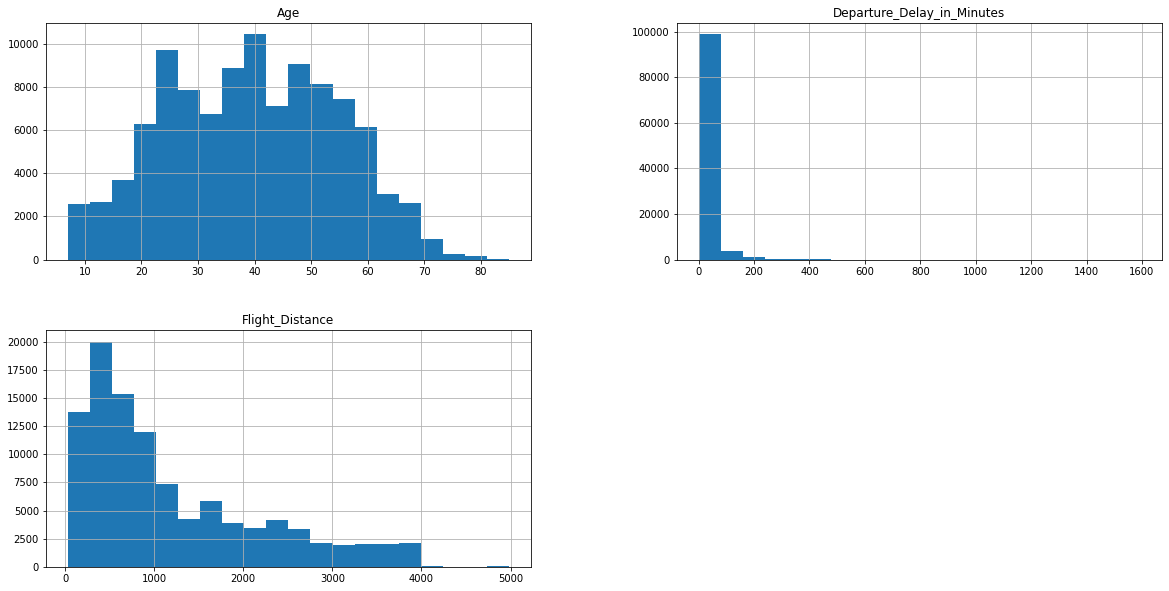

In [21]:
# is het normaal verdeeld?

df = train[['Age','Departure_Delay_in_Minutes', 'Flight_Distance']]
#Kijk of het normaal verdeeld is met shapiro-wilk
for column in df:
  print(f'Column : {df[column].name}')

  stat, p = stats.shapiro(df[column])
  print('Statistics=%.3f, p=%.3f' % (stat, p))
  alpha = 0.05
  if p > alpha:
      print('Sample looks Gaussian\n')
  else:
      print('NOT Gaussian\n')
  
df.hist(bins = 20, figsize = (20,10))

# T-test

In [22]:
stats.ttest_ind(satisfied['Flight_Distance'], unsatisfied['Flight_Distance'], equal_var = False)

Ttest_indResult(statistic=96.4236146804019, pvalue=0.0)

In [23]:
stats.ttest_ind(satisfied['Departure_Delay_in_Minutes'], unsatisfied['Departure_Delay_in_Minutes'], equal_var = False)

Ttest_indResult(statistic=-16.574821725609695, pvalue=1.2767076513246778e-61)

In [24]:
stats.ttest_ind(satisfied['Age'], unsatisfied['Age'], equal_var = False)

Ttest_indResult(statistic=46.1415355444016, pvalue=0.0)

# Anova

In [25]:
# Kijken naar de leeftijd in de 3 groepen van class
train['Class'].replace({'Business': 1, 'Eco Plus': 2, 'Eco': 3},inplace = True)

In [26]:
# kijken of er een verschil is
stats.f_oneway(train['Age'][train['Class'] == 1],
               train['Age'][train['Class'] == 2],
               train['Age'][train['Class'] == 3])

F_onewayResult(statistic=1055.254253664797, pvalue=0.0)

1055 geeft aan dat er een groot verschil zit tussen de groepen. Nu t-toetsen doen om te kijken waar het verschil zit.

## Variantie

Nu kijken of de variantie in de groepen gelijk is door middel van levene's test

In [27]:
# levene
stats.levene(train['Age'][train['Class'] == 1],
             train['Age'][train['Class'] == 2],
             train['Age'][train['Class'] == 3])

LeveneResult(statistic=2704.7741588413473, pvalue=0.0)

## Mediaan

In [28]:
Age_business_class = train[train['Class'] == 1]['Age']
Age_eco_plus = train [train ['Class'] == 2]['Age']
Age_eco = train [train ['Class'] == 3]['Age']


print(np.median(Age_business_class))
print(np.median(Age_eco_plus))
print(np.median(Age_eco))

42.0
37.0
36.0


Per groep is de middelste waarde dus best verschillend.

# Kruskal wallis

In [29]:
# Kruskal Wallis test
stats.kruskal(train['Age'][train['Class'] == 1],
              train['Age'][train['Class'] == 2],
              train['Age'][train['Class'] ==3])
                       

KruskalResult(statistic=2198.9559090901525, pvalue=0.0)

Kruskal wallis eeft een significant verschil.

In [30]:
import statsmodels.stats.multicomp as mc

# post hoc test met tukey correctie
comp = mc.MultiComparison(train['Age'], train['Class'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()



group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-2.9198,0.001,-3.3544,-2.4852,True
1,3,-4.4101,0.001,-4.6361,-4.1841,True
2,3,-1.4903,0.001,-1.9267,-1.0539,True


# Anova

Nu de echte anova

In [31]:
aov = pg.anova(data=train, dv='Age', between='Class', detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,Class,4.725812e+05,2,236290.576129,1055.254254,0.0,0.019908
1,Within,2.326532e+07,103901,223.918146,NaN,NaN,NaN


In [32]:
# welch's anova
aov = pg.welch_anova(dv='Age', between='Class', data=train)
aov

,Source,ddof1,ddof2,F,p-unc,np2
0,Class,2,20223.147758,1071.822594,0.0,0.019908


#Chi square

de niet-parametrische chi-square toets om te bekijken of er een verschil is tussen tevredenheid en klasse

In [33]:
crosstab = rp.crosstab(train['satisfaction'], train['Class'], prop= "col")
crosstab

Class                        
Class              1       2       3     All
satisfaction                                
0              30.57   75.39   81.39   56.67
1              69.43   24.61   18.61   43.33
All           100.00  100.00  100.00  100.00

In [34]:
#chi square: de score, significantie, vrijheidsgraden en de verwachtte scores als er geen verschil is
rp.crosstab(train['satisfaction'], train['Class'], test= "chi-square")

(              Class                     
 Class             1     2      3     All
 satisfaction                            
 0             15185  5650  38044   58879
 1             34480  1844   8701   45025
 All           49665  7494  46745  103904,
                 Chi-square test     results
 0  Pearson Chi-square ( 2.0) =   26471.8629
 1                    p-value =       0.0000
 2                 Cramer's V =       0.5047)

De chi-square is 26471.8629, het is significant. Cramers v is voor de effect size, deze is 0.5 en wijst dus op een sterke samenhang.

In [35]:
rp.crosstab(train['satisfaction'], train['Gender'], test= "chi-square")

(             Gender               
 Gender       Female   Male     All
 satisfaction                      
 0             30193  28686   58879
 1             22534  22491   45025
 All           52727  51177  103904,                 Chi-square test  results
 0  Pearson Chi-square ( 1.0) =   15.4937
 1                    p-value =    0.0001
 2               Cramer's phi =    0.0122)

De chi-square is 26471.8629, het is significant. Cramers phi voor 2x2 tabellen is voor de effect size, deze is 0.01 en wijst dus op een zwakke samenhang.

# Zscore

In [36]:
from sklearn.preprocessing import StandardScaler

# omzetten naar z-scores om de regressie analyse uit te voeren.
scaler = StandardScaler()
data_z = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
print(data_z[0:5])

        Age  Departure_Delay_in_Minutes  Flight_Distance
0 -1.745279                    0.266393        -0.731539
1 -0.951360                   -0.361375        -0.957184
2 -0.885200                   -0.387532        -0.047584
3 -0.951360                   -0.099805        -0.629246
4  1.430397                   -0.387532        -0.978244


# Regressie analyse

In [ ]:
z_train = data_z + train.satisfaction
model= smf.logit(formula="satisfaction ~ Age + Flight_Distance + Departure_Delay_in_Minutes", data= z_train).fit()
model.summary()